In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import datasets, transforms
import torch
from scipy.ndimage import zoom as scizoom
from PIL import Image as PILImage
from io import BytesIO

import skimage as sk
from skimage.filters import gaussian
from io import BytesIO
from wand.image import Image as WandImage
from wand.api import library as wandlibrary
import wand.color as WandColor
import ctypes
from PIL import Image as PILImage
import cv2
from scipy.ndimage import zoom as scizoom
from scipy.ndimage.interpolation import map_coordinates
import warnings

C:\Users\thanh-dung.le\AppData\Local\Temp\ipykernel_121600\3267870239.py:21: DeprecationWarning: Please import `map_coordinates` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.interpolation import map_coordinates


In [6]:
# Extend wand.image.Image class to include method signature
class MotionImage(WandImage):
    def motion_blur(self, radius=0.0, sigma=0.0, angle=0.0):
        wandlibrary.MagickMotionBlurImage(self.wand, radius, sigma, angle)

In [7]:
# Paths
DATASET_PATH = 'C:\\Users\\thanh-dung.le\\Documents\\EuroSat_Satellite\\EuroSAT_RGB'
TEST_PATH = os.path.join(DATASET_PATH, 'test')

# Create output directories for different severity levels
output_dir = './noisy_test_data/data_motionblur'
severity_levels = [1, 2, 3, 4, 5]

for severity in severity_levels:
    for class_name in os.listdir(TEST_PATH):
        os.makedirs(os.path.join(output_dir, f'severity_{severity}', class_name), exist_ok=True)

# Data transformation
data_transforms = transforms.Compose([
    transforms.Resize(64),
    transforms.ToTensor(),
])

# Load the test dataset
test_dataset = datasets.ImageFolder(TEST_PATH, data_transforms)

def apply_motion_blur(image, severity=1):
    #c = [(10, 3), (15, 5), (15, 8), (15, 12), (20, 15)][severity - 1]
    c = [(5, 1.5), (5, 2), (5, 4), (5, 3), (10, 5)][severity - 1] #Inference
    #c = [(7.5, 1.5), (10, 3), (10, 4), (10, 6), (15, 7.5)][severity - 1] 

    # Convert tensor to PIL Image
    image_pil = transforms.ToPILImage()(image)

    output = BytesIO()
    image_pil.save(output, format='PNG')
    image = MotionImage(blob=output.getvalue())

    image.motion_blur(radius=c[0], sigma=c[1], angle=np.random.uniform(-45, 45))

    image = cv2.imdecode(np.frombuffer(image.make_blob(), np.uint8), cv2.IMREAD_UNCHANGED)

    # If the image is not 3-channel, convert it to RGB
    if image.ndim == 2:
        image = np.stack([image] * 3, axis=-1)
    elif image.shape[2] == 4:
        image = image[..., :3]

    return np.clip(image[..., [2, 1, 0]], 0, 255)  # BGR to RGB

# Process and save noisy images
for idx, (image, label) in enumerate(test_dataset):
    for severity in severity_levels:
        # Add motion blur noise to the image
        noisy_image = apply_motion_blur(image, severity)

        # Convert the numpy array back to a PIL image
        noisy_image_pil = PILImage.fromarray(noisy_image.astype(np.uint8))

        # Save the noisy image
        class_dir = test_dataset.classes[label]
        output_path = os.path.join(output_dir, f'severity_{severity}', class_dir)
        os.makedirs(output_path, exist_ok=True)
        noisy_image_pil.save(os.path.join(output_path, f'{idx}.png'))

print('Noisy test datasets with motion blur noise created successfully.')

Noisy test datasets with motion blur noise created successfully.


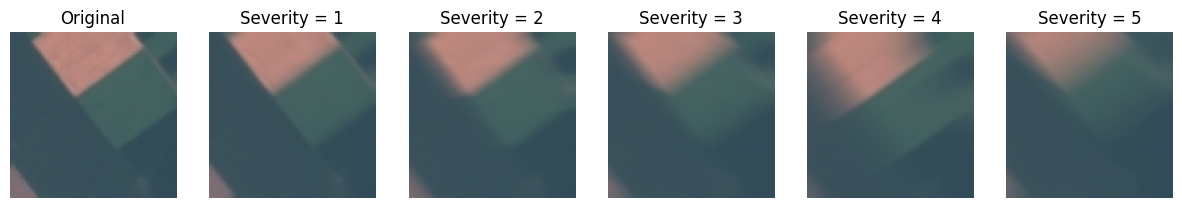

In [8]:
# Show comparison of the original image and noisy images
def show_comparison(idx):
    fig, axes = plt.subplots(1, 6, figsize=(15, 5))
    
    original_image, label = test_dataset[idx]
    original_image_pil = transforms.ToPILImage()(original_image)
    
    axes[0].imshow(original_image_pil)
    axes[0].set_title("Original")
    axes[0].axis('off')
    
    for i, severity in enumerate(severity_levels, 1):
        noisy_image = apply_motion_blur(original_image, severity)
        noisy_image_pil = transforms.ToPILImage()(noisy_image)
        
        axes[i].imshow(noisy_image_pil)
        axes[i].set_title(f"Severity = {severity}")
        axes[i].axis('off')
    
    plt.show()

# Show comparison for the first image in the test dataset
show_comparison(0)